# L.A. County places timeseries

In [1]:
# !/opt/anaconda3/bin/python -m pip install nb-black

In [2]:
%load_ext lab_black

In [3]:
import pandas as pd
import geopandas as gpd
import jenkspy
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline
import json
import numpy as np
import altair as alt
import altair_latimes as lat

In [5]:
import requests
from bs4 import BeautifulSoup
import re
import unicodedata
from datetime import datetime, date

In [6]:
alt.themes.register("latimes", lat.theme)
alt.themes.enable("latimes")
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

---

In [7]:
surge_begin = "2020-11-15"
surge_end = "2021-01-15"

### Fetch cases timeseries from LAT coronavirus tracker repo

In [8]:
cases = pd.read_csv(
    "../../coronavirus-tracker/_notebooks/data/processed/places/timeseries.csv",
    low_memory=False,
)

In [9]:
cases[cases["date"] == "2020-12-31"]

name        date   county  fips                 slug  \
307           94501: Alameda  2020-12-31  Alameda     1        94501-alameda   
662           94502: Alameda  2020-12-31  Alameda     1        94502-alameda   
1017    94505: Discovery Bay  2020-12-31  Alameda     1  94505-discovery-bay   
1372          94536: Fremont  2020-12-31  Alameda     1        94536-fremont   
1727          94538: Fremont  2020-12-31  Alameda     1        94538-fremont   
...                      ...         ...      ...   ...                  ...   
401202            Marysville  2020-12-31     Yuba   115           marysville   
401415      Olivehurst Linda  2020-12-31     Yuba   115     olivehurst-linda   
401628                 Other  2020-12-31     Yuba   115                other   
401841           Plumas Lake  2020-12-31     Yuba   115          plumas-lake   
402054             Wheatland  2020-12-31     Yuba   115            wheatland   

       confirmed_cases_note  confirmed_cases        lat         lon  \
307                     NaN             1038  37.774606 -122.274583   
662                     NaN              145  37.736988 -122.241149   
1017                    NaN                0  37.882787 -121.593154   
1372                    NaN             1631  37.570977 -121.987951   
1727                    NaN             1668  37.499148 -121.977924   
...                     ...              ...        ...         ...   
401202                  NaN             1665  39.150000 -121.583333   
401415                  NaN             1112  39.127778 -121.550833   
401628                  NaN              227        NaN         NaN   
401841                  NaN              396  39.020684 -121.557993   
402054                  NaN              228  39.011038 -121.429152   

        population  zcta_id                id  new_confirmed_cases  \
307        62826.0  94501.0             94501                 39.0   
662        14117.0  94502.0             94502                 11.0   
1017       16382.0  94505.0             94505                  0.0   
1372       72976.0  94536.0             94536                 43.0   
1727       63911.0  94538.0             94538                 51.0   
...            ...      ...               ...                  ...   
401202     12282.0      NaN        Marysville                  0.0   
401415     32623.0      NaN  Olivehurst Linda                  0.0   
401628         NaN      NaN             Other                  0.0   
401841      7367.0      NaN       Plumas Lake                  0.0   
402054      3747.0      NaN         Wheatland                  0.0   

        new_confirmed_cases_seven_day_total  \
307                                   115.0   
662                                    19.0   
1017                                    0.0   
1372                                  171.0   
1727                                  186.0   
...                                     ...   
401202                                205.0   
401415                                 93.0   
401628                                 14.0   
401841                                 27.0   
402054                                 29.0   

        new_confirmed_cases_seven_day_average  \
307                                 16.428571   
662                                  2.714286   
1017                                 0.000000   
1372                                24.428571   
1727                                26.571429   
...                                       ...   
401202                              29.285714   
401415                              13.285714   
401628                               2.000000   
401841                               3.857143   
402054                               4.142857   

        new_confirmed_cases_fourteen_day_total  \
307                                      258.0   
662                                       36.0   
1017                                       0.0   
1372           

### Isolate those places in Los Angeles County

In [10]:
places = cases[(cases["zcta_id"].isna()) & (cases["county"] == "Los Angeles")]

### Limit the dataframe to places with > 3000 population

In [11]:
places_lg = places[places["population"] >= 3000]

---

### Get neightborhoods and regions in LA County from U.S. Census

In [12]:
census = pd.read_csv("output/places_totals.csv")

### Merge with our LA cases dataframe

In [13]:
places_lrg = pd.merge(places_lg, census[["name", "rsa"]], on="name", how="left")

---

### Trim the dataframe to cases during the surge

In [14]:
surge_places = places_lrg[
    (places_lrg["date"] >= surge_begin) & (places_lrg["date"] <= surge_end)
][["name", "rsa", "date", "new_confirmed_cases_seven_day_per_100k"]]

### Aggregate up to LA County as a whole

In [15]:
lacounty_all = (
    surge_places.groupby(["date"])
    .agg({"new_confirmed_cases_seven_day_per_100k": "mean"})
    .reset_index()
)

### Same for regions in LA County (Westside, Antelope Valley, etc)

In [16]:
regions = (
    surge_places.groupby(["rsa", "date"])
    .agg({"new_confirmed_cases_seven_day_per_100k": "mean"})
    .reset_index()
)

### Append LA County figures into places dataframe for context

In [17]:
lacounty_all["name"] = "Los Angeles County"

In [18]:
lacounty_all["rsa"] = "Los Angeles County"

In [19]:
surge_places = surge_places.append(lacounty_all, ignore_index=True)

### Let's export a wide CSV for each place for graphics

In [20]:
places_list = ["West Hollywood", "Malibu", "Playa Del Rey"]

In [21]:
for p in places_list:
    compare_places = (
        pd.pivot_table(
            surge_places[
                (surge_places["name"] == f"{p}")
                | (surge_places["name"] == "Los Angeles County")
            ][["date", "name", "new_confirmed_cases_seven_day_per_100k"]],
            values="new_confirmed_cases_seven_day_per_100k",
            index=["date"],
            columns=["name"],
        )
        .reset_index()
        .to_csv(
            "output/compare_places-" + (f"{p}").lower().replace(" ", "-") + ".csv",
            index=False,
        )
    )

### Chart cange in coronavirus rate/100k by L.A. County region

In [22]:
allregions_chart = (
    alt.Chart(regions)
    .mark_area()
    .encode(
        x=alt.X(
            "date:T",
            axis=alt.Axis(
                tickCount=4,
                format=("%b. %-d"),
                grid=False,
                tickColor="#ffffff",
                title="",
            ),
        ),
        y=alt.Y(
            "new_confirmed_cases_seven_day_per_100k",
            title="",
            axis=alt.Axis(tickColor="#ffffff"),
        ),
        facet=alt.Facet("rsa:N", title="", columns=5),
        #         color=alt.Color("rsa:N", scale=alt.Scale(scheme="category20"), title=" "),
    )
    .properties(
        width=200,
        height=200,
        title="Change in coronavirus rate/100k, by L.A. County region",
    )
    .configure_axis()
    .configure_legend(symbolType="stroke")
)

In [23]:
allregions_chart

alt.Chart(...)

In [24]:
# allcities_chart.save("visuals/allregions_chart_min_multiples.png")

---

## Change from Nov. 15 to Jan. 15?

In [25]:
surge_change = places_lrg[
    (places_lrg["date"] == surge_begin) | (places_lrg["date"] == surge_end)
][["name", "rsa", "date", "new_confirmed_cases_seven_day_per_100k"]]

### Make the change dataframe wide 

In [26]:
surge_change_pivot = (
    pd.pivot_table(
        surge_change[surge_change["new_confirmed_cases_seven_day_per_100k"] > 0],
        values="new_confirmed_cases_seven_day_per_100k",
        index=["name", "rsa"],
        columns=["date"],
    )
    .dropna()
    .reset_index()
)

### Clean up column headers, round figures and remove places with no cases

In [27]:
surge_change_pivot.rename(
    columns={"2020-11-15": "mid_november", "2021-01-15": "mid_january"}, inplace=True
)

In [28]:
surge_change_pivot[["mid_november", "mid_january"]] = round(
    surge_change_pivot[["mid_november", "mid_january"]], 2
)

In [29]:
surge_change_pivot = surge_change_pivot[surge_change_pivot["mid_november"] > 0]

### LA County increase percentage?

In [30]:
round(
    (
        (
            surge_change_pivot["mid_january"].sum()
            - surge_change_pivot["mid_november"].sum()
        )
        / surge_change_pivot["mid_november"].sum()
    )
    * 100,
    2,
)

454.57

### Calculate the change

In [31]:
surge_change_pivot["pct_change"] = round(
    (
        (surge_change_pivot["mid_january"] - surge_change_pivot["mid_november"])
        / surge_change_pivot["mid_november"]
    )
    * 100,
    2,
)

### Which places had the smallest increase in coronavirus rates? 

In [32]:
surge_change_pivot.sort_values("pct_change", ascending=True).head(20)

date                   name                     rsa  mid_november  \
125           Playa Del Rey                Westside        250.31   
117     Palisades Highlands                Westside        104.00   
183          West Hollywood            Central L.A.        211.09   
3                Agua Dulce        Northwest County        240.50   
100                  Malibu  Santa Monica Mountains        100.30   
38                 Del Aire               South Bay         91.05   
47            East Pasadena      San Gabriel Valley         46.85   
56                   Encino     San Fernando Valley        172.67   
76          Hollywood Hills            Central L.A.        139.29   
131             Rancho Park                Westside        106.71   
20                Brentwood                Westside        125.99   
172                  Venice                Westside        103.29   
144            Santa Monica                Westside        128.72   
147            Sierra Madre      San Gabriel Valley         81.90   
161                 Tarzana     San Fernando Valley        242.91   
39                  Del Rey                Westside        136.96   
98                Los Feliz            Central L.A.        106.44   
134   Rolling Hills Estates               South Bay         61.63   
42                 Downtown            Central L.A.        269.02   
139             San Gabriel      San Gabriel Valley        217.32   

date  mid_january  pct_change  
125        187.73      -25.00  
117        130.01       25.01  
183        308.52       46.16  
3          408.85       70.00  
100        208.32      107.70  
38         227.63      150.01  
47         124.94      166.68  
56         464.89      169.24  
76         397.50      185.38  
131        304.88      185.71  
20         377.97      200.00  
172        309.87      200.00  
144        390.50      203.37  
147        254.80      211.11  
161        796.74      228.00  
39         454.30      231.70  
98         360.98      239.14  
134        209.54      240.00  
42         941.58      250.00  
139        764.27      251.68

### And the greatest increase? 

In [33]:
surge_change_pivot.sort_values("pct_change", ascending=False).head(10)

date               name                 rsa  mid_november  mid_january  \
140          San Marino  San Gabriel Valley         15.06       316.34   
93         Leimert Park          South L.A.         59.07       774.53   
174      Vermont Square          South L.A.        156.72      1828.39   
153   South San Gabriel  San Gabriel Valley         90.42      1039.78   
78            Hyde Park          South L.A.        101.61      1152.73   
143    Santa Fe Springs           Southeast        119.80      1236.11   
18          Beverlywood            Westside         53.14       538.98   
10      Avocado Heights  San Gabriel Valley        118.08      1195.57   
119               Palms            Westside         82.05       818.20   
49        East Whittier  San Gabriel Valley         94.23       904.64   

date  pct_change  
140      2000.53  
93       1211.21  
174      1066.66  
153      1049.94  
78       1034.47  
143       931.81  
18        914.26  
10        912.51  
119       897.20  
49        860.03

### Rank them

In [34]:
surge_change_pivot["rank_lower_is_better"] = surge_change_pivot["pct_change"].rank(
    method="max"
)

In [65]:
surge_change_pivot.sort_values("rank_lower_is_better", ascending=True).head(10)

date                 name                     rsa  \
125         Playa Del Rey                Westside   
117   Palisades Highlands                Westside   
183        West Hollywood            Central L.A.   
3              Agua Dulce        Northwest County   
100                Malibu  Santa Monica Mountains   
38               Del Aire               South Bay   
47          East Pasadena      San Gabriel Valley   
56                 Encino     San Fernando Valley   
76        Hollywood Hills            Central L.A.   
131           Rancho Park                Westside   

date  case_rate_per_100k_mid-november  case_rate_per_100k_mid-january  \
125                            250.31                          187.73   
117                            104.00                          130.01   
183                            211.09                          308.52   
3                              240.50                          408.85   
100                            100.30                          208.32   
38                              91.05                          227.63   
47                              46.85                          124.94   
56                             172.67                          464.89   
76                             139.29                          397.50   
131                            106.71                          304.88   

date  pct_change  rank_lower_is_better  
125       -25.00                   1.0  
117        25.01                   2.0  
183        46.16                   3.0  
3          70.00                   4.0  
100       107.70                   5.0  
38        150.01                   6.0  
47        166.68                   7.0  
56        169.24                   8.0  
76        185.38                   9.0  
131       185.71                  10.0

---

### Import geography

In [36]:
places_map = gpd.read_file(
    "input/cities-neighborhoods-unincorporated-la-county-deleted-islands.geojson"
).fillna("")

In [37]:
places_map.head()

NAME                                           geometry
0   Agoura Hills  MULTIPOLYGON (((117201.354 -426752.672, 116472...
1     Bellflower  MULTIPOLYGON (((174818.350 -454427.122, 174810...
2  Beverly Hills  MULTIPOLYGON (((148374.547 -432436.704, 148309...
3        Burbank  MULTIPOLYGON (((156006.516 -426897.025, 156303...
4      Calabasas  MULTIPOLYGON (((120408.368 -426638.916, 120344...

In [38]:
places_map_geo = places_map.merge(
    surge_change_pivot, left_on="NAME", right_on="name", how="outer"
)

In [39]:
len(places_map_geo)

345

In [40]:
places_map_geo.head()

NAME                                           geometry  \
0   Agoura Hills  MULTIPOLYGON (((117201.354 -426752.672, 116472...   
1     Bellflower  MULTIPOLYGON (((174818.350 -454427.122, 174810...   
2  Beverly Hills  MULTIPOLYGON (((148374.547 -432436.704, 148309...   
3        Burbank  MULTIPOLYGON (((156006.516 -426897.025, 156303...   
4      Calabasas  MULTIPOLYGON (((120408.368 -426638.916, 120344...   

            name                     rsa  mid_november  mid_january  \
0   Agoura Hills  Santa Monica Mountains         71.83       397.45   
1     Bellflower               Southeast        144.08      1130.76   
2  Beverly Hills                Westside         98.49       492.47   
3        Burbank     San Fernando Valley        146.48       600.86   
4      Calabasas  Santa Monica Mountains         57.56       386.47   

   pct_change  rank_lower_is_better  
0      453.32                  97.0  
1      684.81                 168.0  
2      400.02                  77.0  
3      310.20                  43.0  
4      571.42                 137.0

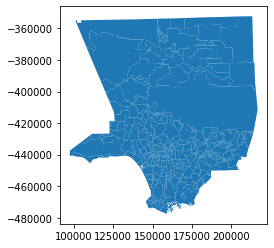

In [41]:
places_map.plot()

---

### Export

In [42]:
places_map_geo = places_map_geo.to_crs("EPSG:4326")

In [43]:
places_map_geo[
    [
        "name",
        "rsa",
        "mid_november",
        "mid_january",
        "pct_change",
        "rank_lower_is_better",
        "geometry",
    ]
].to_file("output/places_map_geo.geojson", driver="GeoJSON")

In [44]:
surge_change_pivot.rename(
    columns={
        "mid_november": "case_rate_per_100k_mid-november",
        "mid_january": "case_rate_per_100k_mid-january",
    },
    inplace=True,
)

In [45]:
len(places_map_geo)

345

In [46]:
places_map_geo[["NAME", "pct_change"]].to_csv("output/places_map.csv", index=False)

In [47]:
!mapshaper "output/places_map_geo.geojson" -simplify dp 20% -o format=geojson "output/places_map_geo_simplified.geojson"

[simplify] Repaired 2 intersections
[o] Wrote output/places_map_geo_simplified.geojson


---

### Add demographics from 07-census-data-places

In [48]:
census = pd.read_csv("output/places_totals.csv")

In [49]:
surge_demos = pd.merge(surge_change_pivot, census, on="name", how="left")

In [50]:
surge_demos.drop(["rsa_y"], axis=1, inplace=True)

In [51]:
surge_demos.rename(columns={"rsa_x": "rsa"}, inplace=True)

### Places with the HIGHEST rates of homes that have seven or more residents

In [52]:
surge_demos[
    [
        "name",
        "rsa",
        "est_total_seven_more_units_pct",
        "pct_change",
        "rank_lower_is_better",
    ]
].sort_values("est_total_seven_more_units_pct", ascending=False).head(10)

name                  rsa  \
48   East Rancho Dominguez               Harbor   
116                Pacoima  San Fernando Valley   
185     West Puente Valley   San Gabriel Valley   
7                   Arleta  San Fernando Valley   
10         Avocado Heights   San Gabriel Valley   
177            Walnut Park            Southeast   
99                 Lynwood            Southeast   
58      Florence-Firestone           South L.A.   
178                  Watts           South L.A.   
149         South El Monte   San Gabriel Valley   

     est_total_seven_more_units_pct  pct_change  rank_lower_is_better  
48                            22.81      378.26                  68.0  
116                           21.03      396.40                  74.0  
185                           19.74      825.02                 181.0  
7                             18.53      374.57                  66.0  
10                            18.48      912.51                 188.0  
177                           17.62      851.63                 184.0  
99                            17.53      583.22                 139.0  
58                            17.31      528.05                 123.0  
178                           17.22      752.69                 177.0  
149                           16.74      430.19                  89.0

### Places with the LOWEST rates of homes that have seven or more residents

In [64]:
surge_demos[
    [
        "name",
        "rsa",
        "est_total_seven_more_units_pct",
        "pct_change",
        "rank_lower_is_better",
    ]
].sort_values("est_total_seven_more_units_pct", ascending=True).head(20)

name                  rsa  est_total_seven_more_units_pct  \
104     Marina del Rey             Westside                            0.03   
25             Carthay         Central L.A.                            0.04   
183     West Hollywood         Central L.A.                            0.06   
27        Century City             Westside                            0.10   
76     Hollywood Hills         Central L.A.                            0.15   
73       Hermosa Beach            South Bay                            0.16   
20           Brentwood             Westside                            0.18   
189           Westwood             Westside                            0.25   
156        Studio City  San Fernando Valley                            0.26   
163        Toluca Lake  San Fernando Valley                            0.29   
39             Del Rey             Westside                            0.30   
144       Santa Monica             Westside                            0.31   
102    Manhattan Beach            South Bay                            0.33   
42            Downtown         Central L.A.                            0.36   
115  Pacific Palisades             Westside                            0.36   
146       Sherman Oaks  San Fernando Valley                            0.42   
98           Los Feliz         Central L.A.                            0.43   
125      Playa Del Rey             Westside                            0.46   
56              Encino  San Fernando Valley                            0.47   
131        Rancho Park             Westside                            0.47   

     pct_change  rank_lower_is_better  
104      419.99                  86.0  
25       293.32                  34.0  
183       46.16                   3.0  
27       308.33                  40.0  
76       185.38                   9.0  
73       252.39                  21.0  
20       200.00                  12.0  
189      469.07                 106.0  
156      329.98                  53.0  
163      266.67                  25.0  
39       231.70                  16.0  
144      203.37                  13.0  
102      309.97                  42.0  
42       250.00                  19.0  
115      309.06                  41.0  
146      365.26                  64.0  
98       239.14                  17.0  
125      -25.00                   1.0  
56       169.24                   8.0  
131      185.71                  10.0

In [63]:
surge_demos[surge_demos["name"] == "West"]

name                     rsa  case_rate_per_100k_mid-november  \
100  Malibu  Santa Monica Mountains                            100.3   

     case_rate_per_100k_mid-january  pct_change  rank_lower_is_better  \
100                          208.32       107.7                   5.0   

     est_pop  est_latino  est_anglo  est_black  est_asian  \
100   9491.0       621.0     8190.0      136.0      280.0   

     est_total_single_units  est_total_seven_more_units  \
100                   965.0                        30.0   

     est_total_housing_units  median_house_income  est_latino_pct  \
100                   3674.0             125011.0            6.54   

     est_anglo_pct  est_black_pct  est_asian_pct  \
100          86.29           1.43           2.95   

     est_total_seven_more_units_pct  est_total_single_units_pct  
100                            0.82                       26.27

### Places with largest coronavirus rate increases during surge

In [54]:
surge_demos[
    [
        "name",
        "rsa",
        "case_rate_per_100k_mid-november",
        "case_rate_per_100k_mid-january",
        "rank_lower_is_better",
        "pct_change",
        "est_latino_pct",
        "est_total_seven_more_units_pct",
    ]
].sort_values("rank_lower_is_better", ascending=True).tail(10)

name                 rsa  case_rate_per_100k_mid-november  \
49       East Whittier  San Gabriel Valley                            94.23   
119              Palms            Westside                            82.05   
10     Avocado Heights  San Gabriel Valley                           118.08   
18         Beverlywood            Westside                            53.14   
143   Santa Fe Springs           Southeast                           119.80   
78           Hyde Park          South L.A.                           101.61   
153  South San Gabriel  San Gabriel Valley                            90.42   
174     Vermont Square          South L.A.                           156.72   
93        Leimert Park          South L.A.                            59.07   
140         San Marino  San Gabriel Valley                            15.06   

     case_rate_per_100k_mid-january  rank_lower_is_better  pct_change  \
49                           904.64                 186.0      860.03   
119                          818.20                 187.0      897.20   
10                          1195.57                 188.0      912.51   
18                           538.98                 189.0      914.26   
143                         1236.11                 190.0      931.81   
78                          1152.73                 191.0     1034.47   
153                         1039.78                 192.0     1049.94   
174                         1828.39                 193.0     1066.66   
93                           774.53                 194.0     1211.21   
140                          316.34                 195.0     2000.53   

     est_latino_pct  est_total_seven_more_units_pct  
49            51.76                            2.30  
119           22.90                            0.51  
10            85.80                           18.48  
18            10.44                            1.40  
143           82.49                            8.49  
78            36.60                            4.95  
153           41.25                            7.32  
174           63.40                           15.17  
93            25.70                            3.22  
140            6.65                            1.24

### Places with smallest coronavirus rate increases during surge

In [55]:
surge_demos[
    [
        "name",
        "rsa",
        "case_rate_per_100k_mid-november",
        "case_rate_per_100k_mid-january",
        "rank_lower_is_better",
        "pct_change",
        "est_latino_pct",
        "est_total_seven_more_units_pct",
    ]
].sort_values("rank_lower_is_better", ascending=True).head(10)

name                     rsa  \
125        Playa Del Rey                Westside   
117  Palisades Highlands                Westside   
183       West Hollywood            Central L.A.   
3             Agua Dulce        Northwest County   
100               Malibu  Santa Monica Mountains   
38              Del Aire               South Bay   
47         East Pasadena      San Gabriel Valley   
56                Encino     San Fernando Valley   
76       Hollywood Hills            Central L.A.   
131          Rancho Park                Westside   

     case_rate_per_100k_mid-november  case_rate_per_100k_mid-january  \
125                           250.31                          187.73   
117                           104.00                          130.01   
183                           211.09                          308.52   
3                             240.50                          408.85   
100                           100.30                          208.32   
38                             91.05                          227.63   
47                             46.85                          124.94   
56                            172.67                          464.89   
76                            139.29                          397.50   
131                           106.71                          304.88   

     rank_lower_is_better  pct_change  est_latino_pct  \
125                   1.0      -25.00            8.94   
117                   2.0       25.01            3.90   
183                   3.0       46.16           10.50   
3                     4.0       70.00           23.23   
100                   5.0      107.70            6.54   
38                    6.0      150.01           50.16   
47                    7.0      166.68           26.80   
56                    8.0      169.24            9.32   
76                    9.0      185.38            9.48   
131                  10.0      185.71           13.51   

     est_total_seven_more_units_pct  
125                            0.46  
117                            0.54  
183                            0.06  
3                              2.19  
100                            0.82  
38                             3.57  
47                             2.67  
56                             0.47  
76                             0.15  
131                            0.47

In [56]:
surge_demos.sort_values("rank_lower_is_better", ascending=True).to_csv(
    "output/hayley/change_by_community.csv", index=False
)

### What's the relationship between our demographics and coronavirus rates? 

In [57]:
surge_demos_slim = surge_demos[
    [
        "name",
        "rsa",
        "est_pop",
        "case_rate_per_100k_mid-january",
        "pct_change",
        "est_latino_pct",
        "est_anglo_pct",
        "est_black_pct",
        "est_asian_pct",
        "est_total_seven_more_units_pct",
        "est_total_single_units_pct",
        "median_house_income",
    ]
]

In [58]:
surge_demos_slim.corr(method="pearson")

est_pop  case_rate_per_100k_mid-january  \
est_pop                         1.000000                        0.217570   
case_rate_per_100k_mid-january  0.217570                        1.000000   
pct_change                     -0.048741                        0.329937   
est_latino_pct                  0.183659                        0.903094   
est_anglo_pct                  -0.162911                       -0.797633   
est_black_pct                  -0.037142                        0.162424   
est_asian_pct                  -0.009635                       -0.319116   
est_total_seven_more_units_pct  0.089276                        0.841914   
est_total_single_units_pct     -0.116308                       -0.537789   
median_house_income            -0.169849                       -0.761804   

                                pct_change  est_latino_pct  est_anglo_pct  \
est_pop                          -0.048741        0.183659      -0.162911   
case_rate_per_100k_mid-january    0.329937        0.903094      -0.797633   
pct_change                        1.000000        0.240216      -0.401742   
est_latino_pct                    0.240216        1.000000      -0.819773   
est_anglo_pct                    -0.401742       -0.819773       1.000000   
est_black_pct                     0.262234        0.029543      -0.330281   
est_asian_pct                     0.094233       -0.352158      -0.075900   
est_total_seven_more_units_pct    0.258328        0.857498      -0.750123   
est_total_single_units_pct       -0.279286       -0.599738       0.562412   
median_house_income              -0.314771       -0.706204       0.801918   

                                est_black_pct  est_asian_pct  \
est_pop                             -0.037142      -0.009635   
case_rate_per_100k_mid-january       0.162424      -0.319116   
pct_change                           0.262234       0.094233   
est_latino_pct                       0.029543      -0.352158   
est_anglo_pct                       -0.330281      -0.075900   
est_black_pct                        1.000000      -0.248265   
est_asian_pct                       -0.248265       1.000000   
est_total_seven_more_units_pct       0.129619      -0.294317   
est_total_single_units_pct           0.077794      -0.006916   
median_house_income                 -0.339954       0.093047   

                                est_total_seven_more_units_pct  \
est_pop                                               0.089276   
case_rate_per_100k_mid-january                        0.841914   
pct_change                                            0.258328   
est_latino_pct                                        0.857498   
est_anglo_pct                                        -0.750123   
est_black_pct                                         0.129619   
est_asian_pct                                        -0.294317   
est_total_seven_more_units_pct                        1.000000   
est_total_single_units_pct                           -0.674212   
median_house_income                                  -0.578296   

                                est_total_single_units_pct  \
est_pop                                          -0.116308   
case_rate_per_100k_mid-january                   -0.537789   
pct_change                                       -0.279286   
est_latino_pct                                   -0.599738   
est_anglo_pct                                     0.562412   
est_black_pct                                     0.077794   
est_asian_pct                                    -0.006916   
est_total_seven_more_units_pct                   -0.674212   
est_total_single_units_pct                        1.000000   
median_house_income                               0.193066   

                                median_house_income  
est_pop                                   -0.169849  
case_rate_per_100k_mid-january            -0.761804  
pct_change                                -0.314771  
est_latino_pct   

In [59]:
scatter = (
    alt.Chart(surge_demos_slim)
    .mark_circle(size=100)
    .encode(
        x=alt.Y(
            "median_house_income:Q",
            axis=alt.Axis(grid=False, tickCount=6, format="$2,f"),
            title="Median household income",
        ),
        y=alt.Y(
            "case_rate_per_100k_mid-january:Q",
            title="Case rate per 100,000 residents — mid-January",
            axis=alt.Axis(tickColor="#ffffff"),
        ),
        color=alt.Color("rsa", scale=alt.Scale(scheme="category20")),
        size="est_pop:Q",
        tooltip=[
            "name",
            "est_pop",
            "case_rate_per_100k_mid-january",
            "est_total_seven_more_units_pct",
        ],
    )
)

text = (
    alt.Chart(surge_demos_slim)
    .mark_text(align="left", baseline="middle", dx=7, size=12)
    .encode(
        x="median_house_income:Q",
        y="case_rate_per_100k_mid-january:Q",
        text="name",
    )
)

(scatter + text).properties(width=1500, height=1000).configure_view(
    strokeOpacity=0
).configure_axis(labelFontSize=13).configure_legend()

alt.LayerChart(...)

In [60]:
(scatter + text).properties(width=2000, height=2000).save(
    "visuals/places_scatter_house_income.png"
)

In [61]:
surge_change_pivot.sort_values("rank_lower_is_better", ascending=True).head(20).to_csv(
    "output/least_affected_cities.csv", index=False
)